In [1]:
import numpy as np
from tifffile import imread
import napari
import matplotlib.pyplot as plt
import cv2 as cv
from utils import *
from skimage.morphology import skeletonize
from math import sqrt
from skimage.feature import blob_log
from pathlib import Path
import csv
from os.path import exists
from skimage.morphology import binary_erosion

# Distance analysis with napari and python

Napari is a graphical interface for python capable of showing multidimensional data and very well adapted for the work with microscopical data

In [2]:
# run napari
viewer = napari.Viewer()

First of all, we should upload the data that we are going to analyze. At this point we are going to upload separate channels to napari.

In [3]:
# import data
name = '05_mxlaminAC-635P_rxVP1-580' # name of a file
ch1,ch2,ch3,ch4 = read_data(f'data_to_use/2022-02-17_deconvolved_tiff/{name}.ome.tif', viewer) # specify the path if different

Next we will upload segmented lamin signal to the viewer, and add a segmented nucleus. It can be necessary to manually edit the mask for nucleus what can be also done in napari.

In [4]:
# visualize segmented lamin
membrane = ch2
kernel = (15,15)
threshold(membrane, kernel, viewer)

# create a mask for nucleus
segment_nucleus(viewer)

STAR RED_CONF
STAR RED_STED


In [5]:
# manually edit nucleus and save it as variable
nucleus = viewer.layers['nucleus'].data

We are going to skeletonize lamin signal, so it is easier and faster to compute distances to it. It can be also needed to manually edit the skeleton.

In [6]:
# create skeleton of membrane
membrane = viewer.layers['STAR RED_CONF_label'].data
skeleton = skeletonize(membrane/membrane.max())
skeleton = skeleton.astype(np.uint8)
viewer.add_labels(skeleton * randint(0,255), name = 'Lamin skeleton')

<Labels layer 'Lamin skeleton' at 0x28dadfe50>

In [19]:
# manually edit nucleus and save it as variable
skeleton = viewer.layers['Lamin skeleton'].data

Here, we want to compute the optimal value for normalization so we also account for the size of the nucleus in our distances. As a normalization value we take the maximum possible distance from the lamin to any point in nucleus. 

In [20]:
# calculate value for normalization 
nucleus = viewer.layers['nucleus'].data
x,y = np.where(nucleus==1)
centroid = (np.mean(x), np.mean(y))
viewer.add_points(centroid)

# find logest path between centroid and skeleton
membrane_points = np.array(np.where(skeleton)).T
furthest_point = find_furthest_point(centroid, membrane_points)

dist_for_normalization = np.linalg.norm(np.subtract(centroid,furthest_point))
viewer.add_shapes([furthest_point, centroid], shape_type='line', edge_color='red') 

<Shapes layer 'Shapes' at 0x2c611aca0>

Next, we can segment virus particles. And add the detected particles to the viewer.

In [21]:
# show protein
protein = viewer.layers['STAR 580_STED'].data
lamin = viewer.layers['STAR RED_STED'].data
only_protein = np.subtract(protein.astype(float),lamin.astype(float))
only_protein = np.clip(only_protein, 0, 255)
particles = np.where(nucleus != nucleus.max(), 0, only_protein)
particles = np.array(particles, dtype = np.uint8)
viewer.add_image(particles)

<Image layer 'particles' at 0x2c675a9a0>

In [22]:
# blob detection
blobs_log = blob_log(particles, max_sigma=5, num_sigma=10, threshold=0.15)
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)
points = blobs_log[:,:2]
viewer.add_points(points, size=5, symbol='ring', face_color='red')

<Points layer 'points' at 0x2c8ad5520>

And compute the distances.

In [23]:
# analyse distances
membrane_points = np.array(np.where(skeleton)).T

closest_points = []
for point in points: 
    closest_point = find_closest_point(point, membrane_points)
    closest_points.append(closest_point)

closest_points = np.array(closest_points)

In [24]:
# show distances
distances = np.empty((points.shape[0], 2, 2))
distances[:, 0] = points
distances[:, 1] = closest_points

viewer.add_shapes(distances, shape_type='line', edge_color='red')

<Shapes layer 'distances' at 0x2c60e3490>

Now, when distances are computed we can visualize them of a histogram. This histogram is automatically saved to the directory.

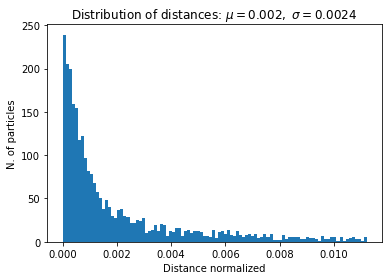

In [25]:
# compute distances
pixel_size_side = 0.02 # micrometers

distances, mean, std = compute_distances(points, pixel_size_side, dist_for_normalization, closest_points)

plt.hist(distances, bins = 100)
plt.ylabel('N. of particles')
plt.xlabel('Distance normalized')
plt.title(f'Distribution of distances: $\mu={round(mean, 4)},\ \sigma={round(std, 4)}$')
plt.savefig(f'{name}.png')

Optionally, we can save all the distances as csv file.

In [26]:
# write results into some file 
distances = np.array(distances)
np.savetxt(f"{name}.csv", distances, delimiter=",")

We can also try to normalize distances to the respective area of the nucleus. For that we will compute area of each bin region. 

In [27]:
# This time we take all of the points in nucleus
points_all = np.where(nucleus)
points_all = np.array(points_all).T

closest_points_all = []
for point in points_all: 
    closest_point = find_closest_point(point, membrane_points)
    closest_points_all.append(closest_point)

closest_points_all = np.array(closest_points_all)
distances_all, mean_all, std_all = compute_distances(points_all, pixel_size_side, dist_for_normalization, closest_points_all)

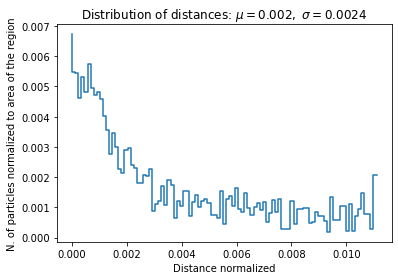

In [29]:
hst1 = np.histogram(distances, bins = 100)
hst2 = np.histogram(distances_all, bins = hst1[1])

normalized = hst1[0] / (hst2[0] + 1)
plt.step(hst1[1][:-1], normalized)
plt.ylabel('N. of particles normalized to area of the region')
plt.xlabel('Distance normalized')
plt.title(f'Distribution of distances: $\mu={round(mean, 4)},\ \sigma={round(std, 4)}$')
plt.savefig(f'{name}_normalized_to_area.png')

## Is this result different from the random distribution?

To answer this question we can simulate the random distribution of particles in nucleus and compute same histogram for the simulated case. 

In [30]:
# generate random coordinates for points inside nucleus
# number of points should be given by real number of points 
n_points = closest_points.shape[0]
# n_points = 10000 # set number of points to generate
points_in_nucleus = generate_points(nucleus, n_points)
viewer.add_points(points_in_nucleus, size=5, symbol='ring', face_color='red')

<Points layer 'points_in_nucleus' at 0x2de958460>

Same again. We compute the distances.

In [31]:
# analyse distances
membrane_points_random = np.array(np.where(skeleton)).T

closest_points_random = []
for point in points_in_nucleus: 
    closest_point = find_closest_point(point, membrane_points_random)
    closest_points_random.append(closest_point)

closest_points_random = np.array(closest_points_random)

And visualize them as a histogram.

Text(0.5, 1.0, 'Distribution of distances from random sampling: $\\mu=0.0039,\\ \\sigma=0.0032$')

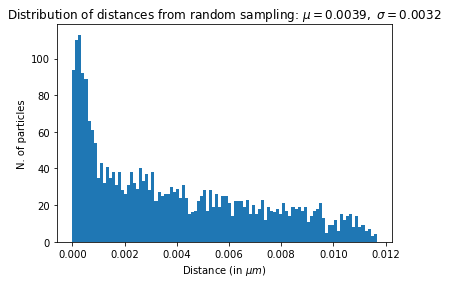

In [32]:
# show distances

# viewer.add_shapes(distances_random, shape_type='line', edge_color='red') 
# dist for normalization can be 1 if no normalization
distances_random, mean_random, std_random = compute_distances(points_in_nucleus, pixel_size_side, dist_for_normalization, closest_points_random)
plt.hist(distances_random, bins = 100)

plt.ylabel('N. of particles')
plt.xlabel('Distance (in $\mu m$)')
plt.title(f'Distribution of distances from random sampling: $\mu={round(mean_random, 4)},\ \sigma={round(std_random, 4)}$')

Divide two histograms.

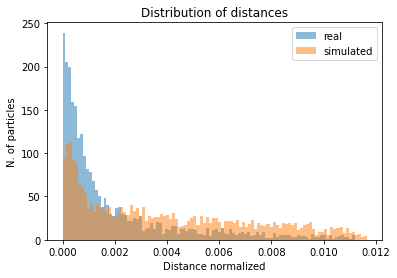

In [33]:
# plot two histograms together
plt.hist(distances, bins = 100, label = 'real', alpha = 0.5)
plt.hist(distances_random, bins = 100, label = 'simulated', alpha = 0.5)
plt.legend()
plt.ylabel('N. of particles')
plt.xlabel('Distance normalized')
plt.title(f'Distribution of distances')
plt.savefig(f'{name}_real_vs_simulated.png')

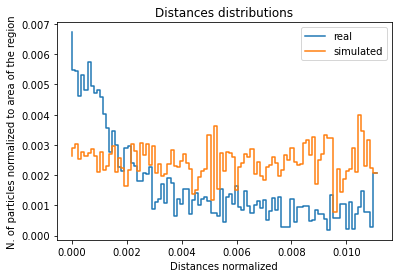

In [34]:

hst1 = np.histogram(distances, bins = 100)
hst2 = np.histogram(distances_all, bins = hst1[1])
hst3 = np.histogram(distances_random, bins = hst1[1])


normalized = hst1[0] / (hst2[0] + 1)
normalized_random = hst3[0] / (hst2[0] + 1)

plt.step(hst1[1][:-1], normalized, label = 'real')
plt.step(hst1[1][:-1], normalized_random, label = 'simulated')

plt.xlabel('Distances normalized')
plt.ylabel('N. of particles normalized to area of the region')

plt.title('Distances distributions')
plt.legend()
plt.savefig(f'{name}_real_vs_simulated_normalized.png')


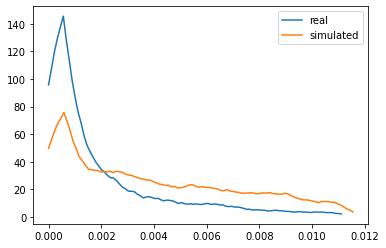

In [35]:
N = 10

hst1 = np.histogram(distances,bins=100)
hst2 = np.histogram(distances_random,bins=100)


distances_blurred = np.convolve(hst1[0], np.ones(N) / N, mode='same')
distances_random_blurred = np.convolve(hst2[0], np.ones(N) / N, mode='same')

hst1_blurred = np.histogram(distances_blurred,bins=100)
hst2_blurred = np.histogram(distances_random_blurred,bins=100)


plt.plot(hst1[1][:-1], distances_blurred, label='real')
plt.plot(hst2[1][:-1], distances_random_blurred, label='simulated')
plt.legend()


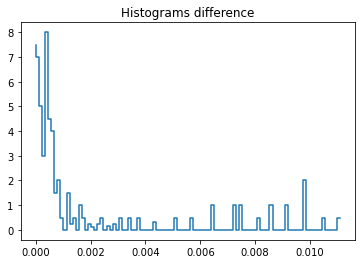

In [36]:
hst_dif = (hst1_blurred[0])/(hst2_blurred[0] + 1)

plt.step(hst1[1][:-1], hst_dif)
plt.title("Histograms difference")
plt.show()

Are distances in real nuclei different from the simulated ones? Statistical tests could tell? Which ones? 

# Pearson correlation coefficient 

We can compute pearson correlation coefficient to compute correlation of intensities inside the nucleus. We compute the Pearson coefficient according to the following formula.

$${\displaystyle r_{xy}={\frac {\sum _{i=1}^{n}(x_{i}-{\bar {x}})(y_{i}-{\bar {y}})}{{\sqrt {\sum _{i=1}^{n}(x_{i}-{\bar {x}})^{2}}}{\sqrt {\sum _{i=1}^{n}(y_{i}-{\bar {y}})^{2}}}}}}$$

In [37]:
# which channels we want to compare? STAR RED_STED (ch3) & STAR 580_STED (ch4)
# we will only compare pixels inside nucleus

pcc_conf = compute_pcc(ch1,ch2,nucleus)
pcc_sted = compute_pcc(ch3,ch4,nucleus)

print(f'Pearson correlation coefficient is {pcc_conf} for confocal channels')
print(f'Pearson correlation coefficient is {pcc_sted} for STED channels')

# save txt file with pcc values
with open(f'pcc.txt', 'a') as f:
    f.write(f'For sample name {name} the Pearson correlation coefficient is {pcc_conf} for confocal channels\n')
    f.write(f'For sample name {name} the Pearson correlation coefficient is {pcc_sted} for STED channels\n')


Pearson correlation coefficient is 0.471 for confocal channels
Pearson correlation coefficient is 0.1926 for STED channels


# Pearson's chi-squared test

In this test we are going to compare the two regions in the nucleus: the membrane-bound part of a nucleus and the central part of it. We test 

$$H_{0} = P(x_{\text membrane}) = P(x_{\text center}) = \frac{1}{2}$$

Using test statistics

The value of the test-statistic is

$${\displaystyle \chi ^{2}=\sum _{i=1}^{n}{\frac {(O_{i}-E_{i})^{2}}{E_{i}}}=N\sum _{i=1}^{n}{\frac {\left(O_{i}/N-p_{i}\right)^{2}}{p_{i}}}}$$

where

${\displaystyle \chi ^{2}}$ = Pearson's cumulative test statistic, which asymptotically approaches a ${\displaystyle \chi ^{2}}$ distribution.

${\displaystyle O_{i}}$ = the number of observations of type i.

${\displaystyle N}$ = total number of observations

${\displaystyle E_{i}=Np_{i}}$ = the expected (theoretical) count of type i, asserted by the null hypothesis that the fraction of type i in the population is ${\displaystyle p_{i}}$

${\displaystyle n}$ = the number of cells in the table.


In [38]:
from skimage.morphology import disk
# get nucleus
nucleus = viewer.layers['nucleus'].data

# create two regions of same area by erosion of nucleus
center_area = 0
membrane_bound_area = np.sum(nucleus)
center = nucleus.copy()
diff = abs(membrane_bound_area - center_area)

while True:
    center = binary_erosion(center, disk(3))
    center_area = np.sum(center)
    membrane_bound_area = np.sum(nucleus) - center_area
    new_diff = abs(membrane_bound_area - center_area)
    if new_diff < diff:
        diff = new_diff
        continue
    else:
        break
    
print(f'Center area is {center_area}')
print(f'Membrane bound area is {membrane_bound_area}')


Center area is 520819
Membrane bound area is 531711


In [39]:
viewer.add_labels(center, name='region 1')
region_2 = nucleus.copy()
region_2[center == 1] = 0
viewer.add_labels(region_2, name='region 2')

<Labels layer 'region 2' at 0x2e0172640>

In [40]:
# compute number of particles in each region
region_1_points = np.array(np.where(center)).T
region_2_points = np.array(np.where(region_2)).T
# take only subset of points that layes in both points_in_nucleus and region_1_points
aset = set([tuple(x) for x in points_in_nucleus])
bset = set([tuple(x) for x in region_1_points])
points_in_region_1 = np.array([x for x in aset & bset])

aset = set([tuple(x) for x in points_in_nucleus])
bset = set([tuple(x) for x in region_2_points])
points_in_region_2 = np.array([x for x in aset & bset])

viewer.add_points(points_in_region_1, size=5, symbol='ring', face_color='red')
viewer.add_points(points_in_region_2, size=5, symbol='ring', face_color='red')

<Points layer 'points_in_region_2' at 0x2de94fac0>

In [41]:
# take number of points_in_region_1
number_of_points_in_region_1 = len(points_in_region_1)
# take number of points_in_region_2
number_of_points_in_region_2 = len(points_in_region_2)

print(number_of_points_in_region_1, number_of_points_in_region_2)

# save info to txt file
with open(f'chisquared_test.txt', 'a') as f:
    f.write(f'For sample name {name} the number of points in center is {number_of_points_in_region_1}\n')
    f.write(f'For sample name {name} the number of points around membrane is {number_of_points_in_region_2}\n')


1244 1386


In [42]:
from scipy.stats import chisquare

chisquare([number_of_points_in_region_1, number_of_points_in_region_2])

Power_divergenceResult(statistic=7.666920152091254, pvalue=0.005624237512819154)

# Batch processing

Here, let's show all the Pearson's correlation coefficients.

In [54]:
# read txt file with pcc values
with open(f'pcc.txt', 'r') as f:
    pcc_values = f.readlines()
    pcc_values = [i.split('is')[1].split('for')[0] for i in pcc_values]
    confocal = [float(pcc_values[i]) for i in range(len(pcc_values)) if i % 2 == 0]
    sted = [float(pcc_values[i]) for i in range(len(pcc_values)) if i % 2 == 1]
sted

[0.2886, 0.2311, 0.407, 0.2689, 0.1926]

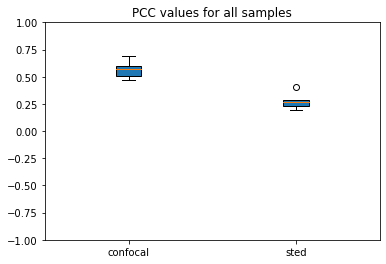

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = [confocal, sted]
fig, ax = plt.subplots()
# set range for y axis
ax.set_ylim(-1, 1)
ax.set_title('PCC values for all samples')
ax.boxplot(data, patch_artist=True, labels=['confocal','sted'])

# save figure
fig.savefig('pcc_boxplot.png')

In [82]:
# read all chi squared values
with open(f'chisquared_test.txt', 'r') as f:
    chisquared_values = f.readlines()
    chisquared_values = [i.split('is')[1].split('for')[0] for i in chisquared_values]
    center = [float(chisquared_values[i]) for i in range(len(chisquared_values)) if i % 2 == 0]
    membrane = [float(chisquared_values[i]) for i in range(len(chisquared_values)) if i % 2 == 1]
membrane

[914.0, 892.0, 894.0, 773.0, 1386.0]

(2, 5)


Power_divergenceResult(statistic=array([173.4612868 , 233.42745421]), pvalue=array([1.89021616e-36, 2.41378991e-49]))

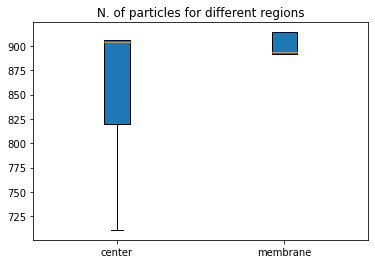

In [80]:
import numpy as np
# make box plot with chi squared values
data = [center, membrane]
fig, ax = plt.subplots()
ax.set_title('N. of particles for different regions')
# don't show outliers
ax.boxplot(data, patch_artist=True, showfliers=False, labels=['center','membrane'])
# save figure
fig.savefig('chisquared_numbers_boxplot.png')